### <u>**Loading Modules**</u>

In [463]:
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt, exp
import random
from matplotlib import pyplot as plt
import networkx as nx
import utm

### <u>**Preparing data**</u>

In [479]:
filepath = "Data/Rajasthan.xlsx"
df = pd.read_excel(filepath)
df.rename(columns={"Unnamed: 0" : "Locations", "Latitude": "Latitude (in degrees)",
 "Longitude": "Longitude (in degrees)"}, inplace=True)
df

,Locations,Latitude (in degrees),Longitude (in degrees)
0,Jaipur,26.9124,75.7873
1,Udaipur,24.5854,73.7125
2,Jodhpur,26.2389,73.0243
3,Jaisalmer,26.9157,70.9083
4,Ajmer,26.4499,74.6399
5,Mount_Abu,24.5926,72.7156
6,Bikaner,28.0176,73.3150
7,Bharatpur,27.2152,77.5030
8,Chittorgarh,24.8829,74.6230
9,Bundi,25.4326,75.6483


### <u>**Graph Representation**</u>

We used matrix representation. <br>
Entry(i,j) = distance b/w node i and node j.

### <u>**Coding Uitility Functions**</u>

**Haversine Formula**: To calculate distance between two locations using their latitude and longitude values. <br>
Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/

In [465]:
# Haversine formula
def dist_formula(lt1,lg1,lt2,lg2):
    lg1 = radians(lg1)
    lg2 = radians(lg2)
    lt1 = radians(lt1)
    lt2 = radians(lt2)
    dlg = lg2 - lg1
    dlt = lt2 - lt1
    a = sin(dlt / 2)**2 + cos(lt1) * cos(lt2) * sin(dlg / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [466]:
def tour_cost(path, distance_matrix):
    dis =0
    for i in range(19):
        ls = [path[i], path[i+1]]
        ls.sort()
        dis += distance_matrix[ls[0]][ls[1]]
    ls = [path[19], path[0]]
    ls.sort()
    dis += distance_matrix[ls[0]][ls[1]]
    return dis

### <u>**Creating Graph**</u>

In [467]:
distance_matrix = np.zeros((20,20)) # distace_matrix[i][j] = distance b/w location i and location j
for i in range(20):
    for j in range(i+1,20):
        distance_matrix[i][j]=dist_formula(df.iloc[i,1],df.iloc[i,2],df.iloc[j,1],df.iloc[j,2])
        distance_matrix[j][i]=distance_matrix[i][j]

In [468]:
G = nx.Graph()
pos = {}
for i in range(20):
    G.add_node(df.iloc[i][0])
    x, y, zone, ut = utm.from_latlon(df.iloc[i][1], df.iloc[i][2]) # to convert long, lat to x-y coordinates
            # reference: https://gis.stackexchange.com/questions/212723/how-can-i-convert-lon-lat-coordinates-to-x-y
    pos[df.iloc[i][0]] = (x,y)

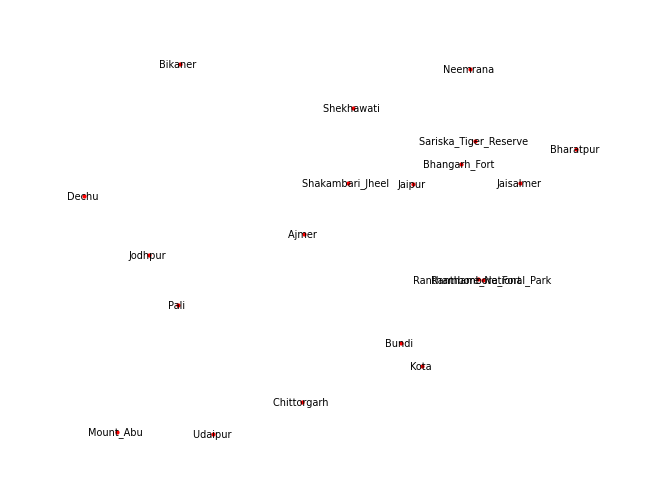

In [469]:
nx.draw(G,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

Let's shift Ranthambore_National_Park co-ordinates for visual clarity.

In [470]:
RNPx,RNPy = pos["Ranthambore_National_Park"]
RNPx,RNPy

(650365.3495993316, 2878464.704691522)

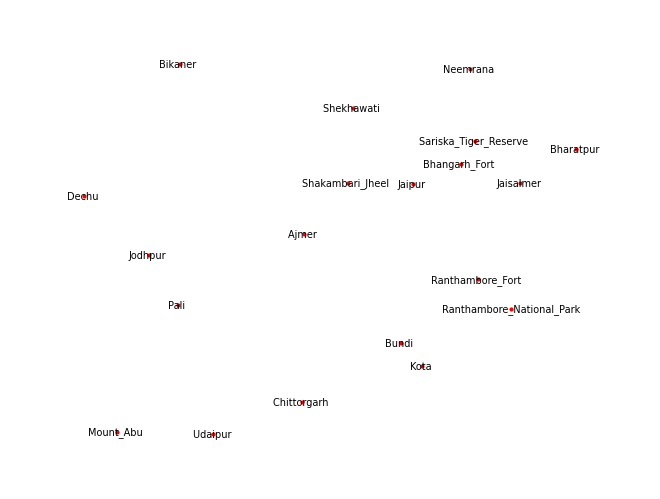

In [471]:
G = nx.Graph()
pos = {}
for i in range(20):
    G.add_node(df.iloc[i][0])
    x, y, zone, ut = utm.from_latlon(df.iloc[i][1], df.iloc[i][2]) # to convert long, lat to x-y coordinates
            # reference: https://gis.stackexchange.com/questions/212723/how-can-i-convert-lon-lat-coordinates-to-x-y
    pos[df.iloc[i][0]] = (x,y)

pos["Ranthambore_National_Park"] = (RNPx+29990,RNPy-29990)

nx.draw(G,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

### <u>**Setting Initial Path Randomly**</u>

Total number of nodes/locations: 20

In [472]:
path = np.random.permutation(20) # initial solution
initial_path = path.copy()
print(initial_path)

[ 1 10 16  2  8 18 11  9 19 14  6 12  5  7 15  4  3  0 17 13]


In [473]:
cost = tour_cost(initial_path,distance_matrix=distance_matrix)
initial_cost=cost
print("Initial Cost: ",initial_cost)

Initial Cost:  5623.731439372121


In [474]:
Tm = 1000
iter_max = 10000
for i in range(1,iter_max):
    two_indices = random.sample(range(20),2)
    two_indices.sort()
    next_path = path.copy()
    next_path[two_indices[0]:two_indices[1]+1] = next_path[two_indices[0]:two_indices[1]+1][::-1] # reverse sublist
    next_cost = tour_cost(next_path,distance_matrix=distance_matrix)
    dE = cost - next_cost # delta Energy
    T = Tm/i
    try:
        pb = 1/(1+exp(-dE/T))
    except: 
        continue
    if dE > 0:
        path = next_path.copy()
    else:
        #random.random() returns a uniformly distributed pseudo-random floating point number in the range [0, 1).
        # This number is less than a given number pb in the range [0,1) with probability pb
        if random.random() < pb:
            path = next_path.copy()
    cost = tour_cost(path,distance_matrix=distance_matrix)
final_cost = cost
final_path = path.copy()
print("Final Cost: ",final_cost)

Final Cost:  2197.5023937403485


In [475]:
print(initial_path)
print(final_path)

[ 1 10 16  2  8 18 11  9 19 14  6 12  5  7 15  4  3  0 17 13]
[19  2 12  5  1  8 10  9  4 15  0 17 18 14  7 13 16 11  6  3]


In [476]:
initial_graph = G.copy()
for i in range(19):
    initial_graph.add_edge(df.iloc[initial_path[i]][0],df.iloc[initial_path[i+1]][0])
initial_graph.add_edge(df.iloc[initial_path[19]][0],df.iloc[initial_path[0]][0])

final_graph = G.copy()
for i in range(19):
    final_graph.add_edge(df.iloc[final_path[i]][0],df.iloc[final_path[i+1]][0])
final_graph.add_edge(df.iloc[final_path[19]][0],df.iloc[final_path[0]][0])

Initial Cost:  5623.731439372121  km


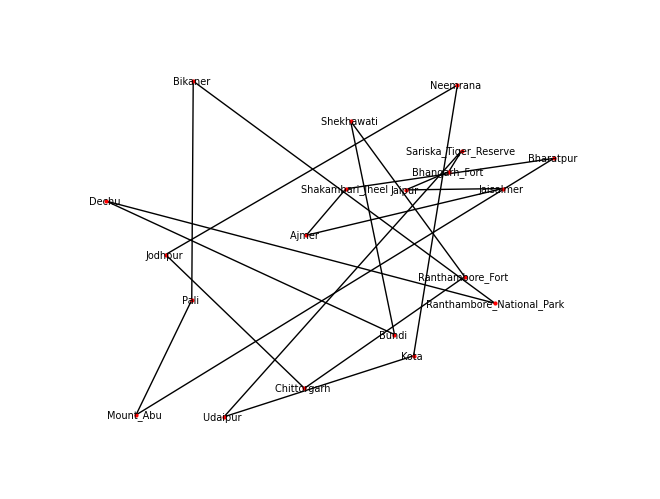

In [477]:
print("Initial Cost: ", initial_cost, " km")
nx.draw(initial_graph,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()

Final Cost:  2197.5023937403485  km


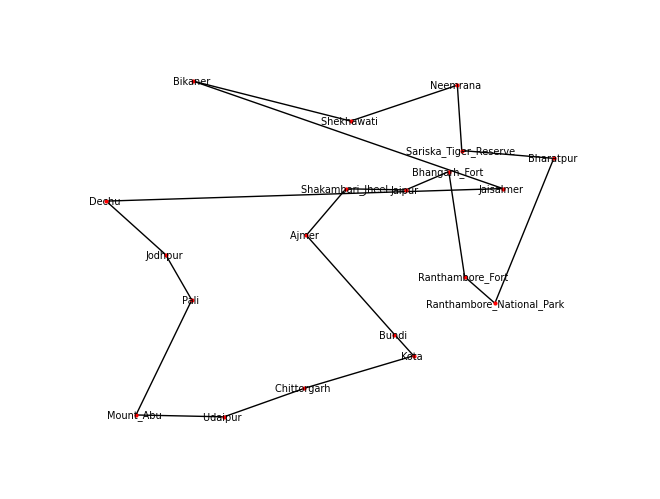

In [478]:
print("Final Cost: ", final_cost, " km")
nx.draw(final_graph,pos=pos,with_labels=True, node_color="red", node_size=4, font_size=7)
plt.margins(0.15)
plt.show()